# MSDS 422 Assignment 3

## Background
Compete in the House Prices:  Advanced Regression Techniques (Links to an external site.) competition, where you will predict house prices in Ames, Iowa (‘SalePrice’).  You will be required to submit predictions to Kaggle.com and provide evidence of those submissions. As part of the analysis, you must address the following at a minimum. 

## Management/Research Question
Based off the information we see from the dataset, we want to determine what variables may be important in determining the Sale Price of a property. This may help in determining reasonable selling prices of future properties.

## Data Exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import warnings

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import IsolationForest

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_log_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures

import sys
!{sys.executable} -m pip install lazypredict
from lazypredict.Supervised import LazyRegressor

/Users/kagenquiballo/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
#no need for ID (arbitrary number)
train = train.drop(labels = 'Id',axis=1)
test = test.drop(labels = 'Id',axis=1)

In [4]:
train.shape

(1460, 80)

There are 1460 records and 80 variables in the training dataset.

In [5]:
train.select_dtypes(include=object).shape

(1460, 43)

43 of the variables are non-numeric variables.

In [6]:
train.select_dtypes(include=np.number).shape

(1460, 37)

37 of the variables are numeric variables.

In [7]:
train.select_dtypes(include=np.number).head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.00,8450,7,5,2003,2003,196.00,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.00,9600,6,8,1976,1976,0.00,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.00,11250,7,5,2001,2002,162.00,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.00,9550,7,5,1915,1970,0.00,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.00,14260,8,5,2000,2000,350.00,655,0,...,192,84,0,0,0,0,0,12,2008,250000


In [8]:
train.select_dtypes(include=object).head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


We get an idea of what the variables may look like by taking a look at a few records. We split it up by numeric and non-numeric data.

Text(0.5, 1.0, 'Boxplot of Sale Prices')

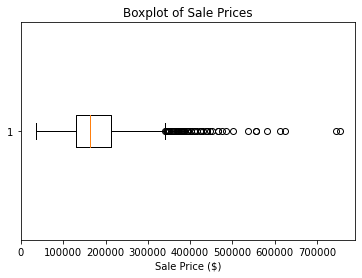

In [9]:
#check histogram of SalePrice
fig, ax = plt.subplots()
plt.boxplot(train["SalePrice"], vert=False)
plt.xlabel('Sale Price ($)')
plt.title('Boxplot of Sale Prices')

In [10]:
train["SalePrice"].describe()

count     1460.00
mean    180921.20
std      79442.50
min      34900.00
25%     129975.00
50%     163000.00
75%     214000.00
max     755000.00
Name: SalePrice, dtype: float64

We see that SalePrice (the variable we are trying to predict) has a approximately normal distribution that is skewed right. The average is ~181k, and can range from ~35k - ~755k. The median sale price is ~163k. We will use standard scaling later on to address the skewed data.

## Data Cleaning

In [11]:
#check for missing data 
train.isnull().sum()[train.isnull().sum()>0].sort_values(ascending=False).head(10)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
dtype: int64

There are 1460 records. Remove variables with over 1000 missing data points.

In [12]:
#drop columns with lots of missing data
train = train.drop(labels = ['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1)
test = test.drop(labels = ['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1)

In [44]:
#fill NA values
#train = train.dropna()
values = {
    'FireplaceQu':"None",
    'LotFrontage': 0,
    'GarageYrBlt': 1880, 
    'GarageType': "None",
    'GarageFinish': "None",
    'GarageQual': "None",
    'GarageCond': "None",
    'BsmtFinType2': "None",
    'BsmtExposure': "None",
    'BsmtFinType1': "None", 
    'BsmtCond': "None",
    'BsmtQual': "None",
    'MasVnrArea': 0,
    'MasVnrType': "None",
    'Electrical': "None",

    'MSZoning': "None",
    'Functional': "None",
    'BsmtHalfBath': 0,
    'BsmtFullBath': 0,
    'Utilities': "None",
    'SaleType': "None",
    'GarageArea': 0,
    'GarageCars': 0,
    'KitchenQual': "None",
    'TotalBsmtSF': 0
    
}

train.fillna(value=values, inplace=True)
test.fillna(value=values, inplace=True)

#see if na's were filled
train.isnull().sum()[train.isnull().sum()>0].sort_values(ascending=False)

Series([], dtype: int64)

For the variables that still have missing data, we can fill these in with 0 or "None" values depending on what makes more sense.

In [14]:
#check for dupes
train.duplicated().sum()

0

There are no duplicate rows in the dataset.

## Feature Selection & Creation
### Feature Selection - Numeric

In [15]:
train.corr()['SalePrice'].sort_values(ascending=False).head(15)

SalePrice      1.00
OverallQual    0.79
GrLivArea      0.71
GarageCars     0.64
GarageArea     0.62
TotalBsmtSF    0.61
1stFlrSF       0.61
FullBath       0.56
TotRmsAbvGrd   0.53
YearBuilt      0.52
YearRemodAdd   0.51
GarageYrBlt    0.50
MasVnrArea     0.47
Fireplaces     0.47
BsmtFinSF1     0.39
Name: SalePrice, dtype: float64

Here we can see the top 15 variables that have a high correlation with SalePrice. Let's draw the cutoff at 0.5 to see which ones are worth including in our models.

In [16]:
#select important numeric variables for analysis
corr_matrix = train.corr()
numeric_cols = list(corr_matrix['SalePrice'][(corr_matrix["SalePrice"] > 0.5)].index)
numeric_cols.remove('SalePrice')
numeric_cols

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea']

Now that we have an idea of what numeric variables to include in our models, lets determine if there is any collinearity between them.

In [17]:
#check for collinearity
X_num = train[numeric_cols]
#correlation matrix
X_num.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea
OverallQual,1.00,0.57,0.55,0.54,0.48,0.59,0.55,0.43,0.56,0.60,0.56
YearBuilt,0.57,1.00,0.59,0.39,0.28,0.20,0.47,0.10,0.73,0.54,0.48
YearRemodAdd,0.55,0.59,1.00,0.29,0.24,0.29,0.44,0.19,0.53,0.42,0.37
TotalBsmtSF,0.54,0.39,0.29,1.00,0.82,0.45,0.32,0.29,0.34,0.43,0.49
1stFlrSF,0.48,0.28,0.24,0.82,1.00,0.57,0.38,0.41,0.27,0.44,0.49
GrLivArea,0.59,0.20,0.29,0.45,0.57,1.00,0.63,0.83,0.27,0.47,0.47
FullBath,0.55,0.47,0.44,0.32,0.38,0.63,1.00,0.55,0.42,0.47,0.41
TotRmsAbvGrd,0.43,0.10,0.19,0.29,0.41,0.83,0.55,1.00,0.16,0.36,0.34
GarageYrBlt,0.56,0.73,0.53,0.34,0.27,0.27,0.42,0.16,1.00,0.74,0.71
GarageCars,0.60,0.54,0.42,0.43,0.44,0.47,0.47,0.36,0.74,1.00,0.88


R(GarageArea, GarageCars) = 0.88 <br />
R(1stFlrSF, TotRmsAbvGrd) = 0.83 <br />
R(GrLivArea, TotalBsmtSF) = 0.82 <br />
R(GarageYrBlt, GarageCars) = 0.80 <br />
We will drop 4 and test again. 

In [18]:
#drop vars
X_num = X_num.drop(['GarageCars', 'TotRmsAbvGrd', '1stFlrSF', 'GarageYrBlt'],axis=1)
#correlation matrix
X_num.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,FullBath,GarageArea
OverallQual,1.00,0.57,0.55,0.54,0.59,0.55,0.56
YearBuilt,0.57,1.00,0.59,0.39,0.20,0.47,0.48
YearRemodAdd,0.55,0.59,1.00,0.29,0.29,0.44,0.37
TotalBsmtSF,0.54,0.39,0.29,1.00,0.45,0.32,0.49
GrLivArea,0.59,0.20,0.29,0.45,1.00,0.63,0.47
FullBath,0.55,0.47,0.44,0.32,0.63,1.00,0.41
GarageArea,0.56,0.48,0.37,0.49,0.47,0.41,1.00


There are no longer any high correlations between numeric predictors.

### Feature Selection - Categorical

In [19]:
# Categorical columns - choose the important ones (based off looking at descriptions)
categorical_cols = ["MSZoning", "BldgType", "Utilities", "Heating", "SaleCondition", "KitchenQual", "LandSlope"]
X_cat = pd.get_dummies(train[categorical_cols], columns=categorical_cols)

MSZoning: The general zoning classification <br />
BldgType: Type of dwelling <br />
Utilities: Type of utilities available <br />
Heating: Type of heating <br />
SaleCondition: Condition of sale <br />
KitchenQual: Kitchen quality <br />
LandSlope: Slope of property <br />
We also recode our cetegorical data here using dummy variables so they can be used in the models.

### Feature Creation

In [20]:
#years between built and remode
X_num['YearBuilt_minus_YearRemodAdd'] = train.apply(lambda x: x['YearBuilt'] - x['YearRemodAdd'],axis=1)
#Uses Qual and Cond
X_num['OverallQual_and_OverallCond'] = train.apply(lambda x: x['OverallQual'] + x['OverallCond'],axis=1)

#drop old vars from X
X_num = X_num.drop(['YearRemodAdd', 'YearBuilt','OverallQual'],axis=1)

We can include a few combinations of variables here as well in order to gain insight from variables that may otherwise for correlated. For example It may be insightful to see how long between building date and remodeling date. A combination of both Quality and Condition may be more insightful than just looking at Quality.

In [21]:
#combine numeric and categoric X
X_final = X_num.join(X_cat)
y = train.SalePrice

#standard scaling
std_scaler = StandardScaler()
numeric_cols = X_final._get_numeric_data().columns 
X_final[numeric_cols] = std_scaler.fit_transform(X_final[numeric_cols])

#cross validation sets from training set
X_train, X_val, y_train, y_val = train_test_split(X_final, y, test_size=0.2, random_state=1)

Our last step before modeling is to combine our predictors, scale them using standard scaling, and split the training data so we can use cross validation.

## Modeling

Here we use a package to test 42 different regressions to see their goodness of fit metrics like their R-Squared and Adjusted R-Squared values. We can also rank them by RMSE by using cross-validation against the testing portion of the training dataset.

In [22]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_val, y_train, y_val)

100%|██████████| 42/42 [00:08<00:00,  5.14it/s]


In [23]:
print(models)

                               Adjusted R-Squared  R-Squared       RMSE  \
Model                                                                     
XGBRegressor                                 0.86       0.88   29557.25   
BaggingRegressor                             0.85       0.87   30088.05   
GradientBoostingRegressor                    0.85       0.87   30270.81   
HistGradientBoostingRegressor                0.84       0.86   31262.64   
PoissonRegressor                             0.84       0.86   31624.44   
RandomForestRegressor                        0.84       0.86   31995.49   
LGBMRegressor                                0.83       0.85   32223.48   
HuberRegressor                               0.80       0.83   34885.08   
RANSACRegressor                              0.80       0.83   34957.62   
PassiveAggressiveRegressor                   0.80       0.82   35397.17   
LassoCV                                      0.80       0.82   35604.96   
LassoLarsCV              

The best model is XGBRegressor with Adjusted R-Squared value of 0.86, a R-Squared of 0.88, and a RMSE value of 29557.25. Let's recreate the model below so we can predict SalePrice for test data. 

In layman's terms, this tells us that the XGBRegressor has the best ability to predict SalePrice based off the predictors (variables) we investigated above. 88% of the variation in the data can be attributed to the predictors we looked at using this specific model. It's great ability to predict saleprice is why we choose this model to predict SalePrice in the testing dataset in the final section.

In [24]:
# XGBRegressor
from xgboost import XGBRegressor
xgbr = xgb.XGBRegressor(verbosity=0) 
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)
xgbr.fit(X_train, y_train)
score = xgbr.score(X_val, y_val)  
print("Training score: ", score)
#Training score:  0.8762093254720652

Training score:  0.8762093254720652


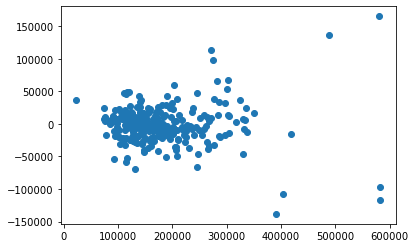

In [25]:
import matplotlib.pyplot as plt
ypred = xgbr.predict(X_val)
plt.scatter(ypred, y_val-ypred)

plt.show()

We can see that the sum of the residuals from this plot is approximately zero. There is homoscedasicity for the majority of points as seen by the even spread in the clump.

In [26]:
# BaggingRegressor (2nd best)
from sklearn.ensemble import BaggingRegressor
reg = BaggingRegressor(random_state=0)
reg.fit(X_train, y_train)
reg.predict(X_train[1:2])
print("Training score: ", reg.score(X_val, y_val))
#Training score:  0.8474507129045956

Training score:  0.8474507129045956


In [27]:
# GradientBoostingRegressor (3rd best)
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
reg.predict(X_train[1:2])
print("Training score: ", reg.score(X_val, y_val))
#Training score:  0.8734785957836944

Training score:  0.8734785957836944


In [28]:
#another model to test: SVR
from sklearn.svm import SVR
svr = SVR(C=1000000)
svr.fit(X_train, y_train)
predictions = svr.predict(X_val)
r_squared = r2_score(predictions, y_val)
print("R2 Score:", r_squared)
rmsle = np.sqrt(mean_squared_log_error(predictions, y_val))
print("RMSLE:", rmsle)
print("Training score: ", svr.score(X_val, y_val))

R2 Score: 0.7756335723070844
RMSLE: 0.1785919918210902
Training score:  0.8422430140166917


As suspected, the XGBRegressor model has the highest score still after re-creating these regression models, and will be used in the final predictions.

## Submission using test data

Score for UserName Kay Quiballo : 0.16008 (xgbr model)

[x] Conduct your analysis using a cross-validation design. <br />
[x] Conduct EDA and provide appropriate visualizations in the process.<br />
[x] Build a minimum of two separate regression models using the training set.<br />
[x] Evaluate polynomial, indicator, dichotomous, & piecewise model components.<br />
[x] Create at least one feature from the data set.<br />
[x] Evaluate the models’ assumptions.<br />
[x] Evaluate goodness of fit metrics on the training and validation sets.<br />
[x] Submit predictions for the unseen test set available on Kaggle.com.<br />
[x] Provide your Kaggle user name and a screen snapshot of your Kaggle scores.<br />
[x] Discuss what your models tell you in layman’s terms

## Continued Analysis - Week 3

[x] Conduct your analysis using a cross-validation design.<br />
[x] Conduct / improve upon previous EDA.<br />
[x] Build models with many variables.<br />
[x] Transform and feature engineer as appropriate.<br />
[x] Build at a minimum the following regression models.<br />
    - [x] Lasso
    - [x] Ridge
    - [x] ElasticNet
[x] Conduct hyperparameter tuning for the ElasticNet.<br />
[x] Evaluate performance of the model using the Kaggle metric upon which your scores are evaluated.<br />
[x] Submit at least two models to Kaggle.com for evaluation. Provider your Kaggle.com user name and screen snapshots of your Kaggle scores.

Here we will run codes for Lasso, Ridge, and ElasticNet as well as incorporate cross validation and tuning.

In [29]:
# Ridge Regression
ridge = Ridge()
ridge.fit(X_train, y_train)
predictions = ridge.predict(X_val)

print("R2 Score:", r2_score(predictions, y_val))
print("RMSLE:", np.sqrt(mean_squared_log_error(predictions, y_val)))
print("Training score: ", ridge.score(X_val, y_val)) #0.821
# XGBR training score:  0.876

R2 Score: 0.7443460353263026
RMSLE: 0.2981062349348306
Training score:  0.8207973505477888


In [30]:
# Lasso Regression
lasso = Lasso()
lasso.fit(X_train, y_train)
predictions = lasso.predict(X_val)

print("R2 Score:", r2_score(predictions, y_val))
print("RMSLE:", np.sqrt(mean_squared_log_error(predictions, y_val)))
print("Training score: ", lasso.score(X_val, y_val)) #0.821
# XGBR training score:  0.876

R2 Score: 0.7446150682231629
RMSLE: 0.2985137556854789
Training score:  0.8208888270021573


In [31]:
# ElasticNet Regression
elasticnet = ElasticNet(alpha=1.0, l1_ratio=0.88)
elasticnet.fit(X_train, y_train)
predictions = elasticnet.predict(X_val)

print("R2 Score:", r2_score(predictions, y_val))
print("RMSLE:", np.sqrt(mean_squared_log_error(predictions, y_val)))
print("Training score: ", elasticnet.score(X_val, y_val)) #0.779 without tuning, 0.810 with tuning
# XGBR training score:  0.876

##### commented out because it takes a long time to run
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
#grid = dict()
#grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
#grid['l1_ratio'] = np.arange(0, 1, 0.01)
#search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#results = search.fit(X_train, y_train)
#print('MAE: %.3f' % results.best_score_) #MAE: -22452.921
#print('Config: %s' % results.best_params_) #Config: {'alpha': 1.0, 'l1_ratio': 0.88}

R2 Score: 0.7066386489418999
RMSLE: 0.2349265947759376
Training score:  0.8096180061264948


Both ridge and lasso have higher training scores of 0.821. Elasticnet intitially had a score of 0.779 but after hyperparameter tuning of alpha and l1_ratio using kfold, its score was improved to 0.810.

## Submission

In [46]:
#Submission using test data

#numerics
corr_matrix = train.corr()
numeric_cols = list(corr_matrix['SalePrice'][(corr_matrix["SalePrice"] > 0.5)].index)
numeric_cols.remove('SalePrice')
X_num = test[numeric_cols]
X_num['YearBuilt_minus_YearRemodAdd'] = test.apply(lambda x: x['YearBuilt'] - x['YearRemodAdd'],axis=1)
X_num['OverallQual_and_OverallCond'] = test.apply(lambda x: x['OverallQual'] + x['OverallCond'],axis=1)
X_num = X_num.drop(['YearRemodAdd', 'YearBuilt','OverallQual', 'GarageCars', 'TotRmsAbvGrd', '1stFlrSF', 'GarageYrBlt'],axis=1)

#categoric
categorical_cols = ["MSZoning", "BldgType", "Utilities", "Heating", "SaleCondition", "KitchenQual", "LandSlope"]
X_cat = pd.get_dummies(test[categorical_cols], columns=categorical_cols)

#combine
X_final = X_num.join(X_cat)

#scale
std_scaler = StandardScaler()
numeric_cols = X_final._get_numeric_data().columns 
X_final[numeric_cols] = std_scaler.fit_transform(X_final[numeric_cols])

#fill missing coded variables
set(list(X_train.columns)) - set(list(X_final.columns))
X_final['Heating_Floor'] = 0
X_final['Heating_OthW'] = 0
X_final['Utilities_NoSeWa'] = 0

#reorder
cols_when_model_builds = xgbr.get_booster().feature_names
X_final = X_final[cols_when_model_builds]

#predict values from test data
test_id = pd.read_csv('test.csv')

ypred = xgbr.predict(X_final)
submit = pd.DataFrame({'Id': test_id['Id'], 'SalePrice': ypred})
submit.to_csv('xgbr.csv',index=False)

ypred = lasso.predict(X_final)
submit = pd.DataFrame({'Id': test_id['Id'], 'SalePrice': ypred})
submit.to_csv('lasso.csv',index=False)

ypred = ridge.predict(X_final)
submit = pd.DataFrame({'Id': test_id['Id'], 'SalePrice': ypred})
submit.to_csv('ridge.csv',index=False)

ypred = elasticnet.predict(X_final)
submit = pd.DataFrame({'Id': test_id['Id'], 'SalePrice': ypred})
submit.to_csv('elasticnet.csv',index=False)

#### Kaggle Scores for UserName "Kay Quiballo" Submissions
xgbr: 0.15937 <br />
lasso: 0.34969 <br />
ridge: 0.34619 <br />
elasticnet: 33363 <br />

After the continued analysis, we see that lasso ridge and elasticnet performed similarly, but not doing nearly as well when predicting SalePrice of testing data using the xgbr model.

# END -- extra code not used in analysis

### The following models were created and run, but did not have significant prediction power, goodness of fit, or cross-validation metrics. These include linear regression, ridge regression, lasso regression, polynomial regression, and piecewise models. They can be run below, but run-time takes a while so they were not included from the analysis.

In [ ]:
#Evaluate polynomial, indicator, dichotomous, & piecewise model components.
# Fitting Polynomial Regression to the dataset
#from sklearn.preprocessing import PolynomialFeatures
 
#poly = PolynomialFeatures(degree = 4)
#X_poly = poly.fit_transform(X_train)
 
#poly.fit(X_poly, y_train)
#lin2 = LinearRegression()
#lin2.fit(X_poly, y)

#note: this code can be run but takes a significant amount of time to pass. 

In [ ]:
# Linear Regression
#lin_reg = LinearRegression()
#lin_reg.fit(X_train, y_train)
#predictions = lin_reg.predict(X_val)
#r_squared = r2_score(predictions, y_val)

#print("R2 Score:", r_squared)
#rmsle = np.sqrt(mean_squared_log_error(predictions, y_val))
#print("RMSLE:", rmsle)
#model.append('Linear Regression')
#error.append(rmsle)

#R2 Score: 0.7445699257777422
#RMSLE: 0.29949680128499373